<a href="https://colab.research.google.com/github/Sanjuktaaich/Product-category-classification/blob/master/imageClassificationFashionDataRN50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
import timeit

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls '/content/drive/My Drive/fashion_data/'

images						      test_images	  text
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5  test_text_data.csv


In [0]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D

num_classes = 11
resnet_weights_path = '/content/drive/My Drive/fashion_data/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5' 
with tf.device('/device:GPU:0'):
  new_model = Sequential()
  new_model.add(ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path))
  new_model.add(Dense(num_classes, activation='softmax'))

  new_model.layers[0].trainable = False

In [0]:
with tf.device('/device:GPU:0'):
  new_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

image_size = 224

data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                              horizontal_flip = True,
                                              width_shift_range = 0.1,
                                              height_shift_range = 0.1)
            
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = data_generator_with_aug.flow_from_directory(
        '/content/drive/My Drive/fashion_data/images/train',
        target_size=(image_size, image_size),
        batch_size=24,
        class_mode='categorical')

validation_generator = data_generator_with_aug.flow_from_directory(
        '/content/drive/My Drive/fashion_data/images/val',
        target_size=(image_size, image_size),
        class_mode='categorical')


Found 2761 images belonging to 11 classes.
Found 693 images belonging to 11 classes.


In [0]:
with tf.device('/device:GPU:0'):
  new_model.fit_generator(
        train_generator,
        steps_per_epoch=8,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=1)

Epoch 1/5
8/8 [==============================] - 16s 2s/step - loss: 0.6736 - acc: 0.8490 - val_loss: 0.6147 - val_acc: 0.8438
Epoch 2/5
8/8 [==============================] - 11s 1s/step - loss: 0.7125 - acc: 0.8402 - val_loss: 0.6021 - val_acc: 0.7500
Epoch 3/5
8/8 [==============================] - 12s 2s/step - loss: 0.5509 - acc: 0.8646 - val_loss: 0.4915 - val_acc: 0.8438
Epoch 4/5
8/8 [==============================] - 14s 2s/step - loss: 0.6197 - acc: 0.8229 - val_loss: 0.5854 - val_acc: 0.7812
Epoch 5/5
8/8 [==============================] - 13s 2s/step - loss: 0.5200 - acc: 0.8906 - val_loss: 0.5718 - val_acc: 0.8438


In [0]:
with tf.device('/device:GPU:0'):
  new_model.layers[0].trainable = True
  new_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
  new_model.fit_generator(
        train_generator,
        steps_per_epoch=8,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=1)

Epoch 1/5
8/8 [==============================] - 35s 4s/step - loss: 0.2465 - acc: 0.9427 - val_loss: 0.2662 - val_acc: 0.9375
Epoch 2/5
8/8 [==============================] - 8s 1s/step - loss: 0.2563 - acc: 0.9323 - val_loss: 0.2360 - val_acc: 0.9375
Epoch 3/5
8/8 [==============================] - 8s 1s/step - loss: 0.1898 - acc: 0.9427 - val_loss: 0.2639 - val_acc: 0.9375
Epoch 4/5
8/8 [==============================] - 12s 2s/step - loss: 0.2085 - acc: 0.9427 - val_loss: 0.3280 - val_acc: 0.9375
Epoch 5/5
8/8 [==============================] - 13s 2s/step - loss: 0.2421 - acc: 0.9290 - val_loss: 0.2206 - val_acc: 0.9375


In [0]:
new_model.save("/content/drive/My Drive/fashion_data/resnet_model23.h5")

In [0]:
from tensorflow.python.keras.models import load_model

# load model 
model = load_model('/content/drive/My Drive/fashion_data/resnet_model23.h5')
# summarize model.
model.summary()

In [0]:
# test on validation set
test_generator = data_generator_no_aug.flow_from_directory(
                '/content/drive/My Drive/fashion_data/images/val',
                target_size=(image_size, image_size),
                class_mode=None,
                shuffle=False)
test_generator.reset()

Found 693 images belonging to 11 classes.


In [0]:
with tf.device('/device:GPU:0'):
  pred = model.predict_generator(test_generator,
                steps=22,
                verbose=1)

22/22 [==============================] - 27s 1s/step


In [0]:
print(pred.shape)

(693, 11)


In [0]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
preds = np.argmax(pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, preds))
labels = test_generator.class_indices
labels = labels.keys()
print('Classification Report')
print(classification_report(test_generator.classes, preds, target_names=labels))

Confusion Matrix
[[ 92   0   0   0   1   0   0   3   0   2   2]
 [  0  75   0   0   0   1   0   0   0   0   2]
 [  0   1  95   0   0   1   0   3   0   0   0]
 [  0   4   0   0   0   0   0   0   0   0   0]
 [  0   5   0   0  93   0   0   0   0   0   1]
 [  0   2   0   0   0   1   0   0   0   0   9]
 [  0   1   0   0   0   0  62   0   0   1   1]
 [  0   0   0   0   0   0   0 100   0   0   0]
 [  0   2   0   0   0   0   0   0   9   3   0]
 [  0   7   0   0   0   0   1   0   1  12   0]
 [  0   4   0   0   0   0   0   0   0   0  96]]
Classification Report
              precision    recall  f1-score   support

         BAG       1.00      0.92      0.96       100
       DRESS       0.74      0.96      0.84        78
     JEWELRY       1.00      0.95      0.97       100
    JUMPSUIT       0.00      0.00      0.00         4
    LINGERIE       0.99      0.94      0.96        99
   OUTERWEAR       0.33      0.08      0.13        12
        PANT       0.98      0.95      0.97        65
        SH

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
test_generator = data_generator_no_aug.flow_from_directory(
        '/content/drive/My Drive/fashion_data/test_images',
        target_size=(image_size, image_size),
        class_mode=None,
        shuffle=False)

test_generator.reset()

Found 1000 images belonging to 1 classes.


In [0]:
with tf.device('/device:GPU:0'):
  pred = new_model.predict_generator(test_generator,
                steps=32,
                verbose=1)

32/32 [==============================] - 442s 14s/step


In [0]:
print(pred.shape)
print(test_generator[0].shape)

(1000, 11)
(32, 224, 224, 3)


In [0]:
import numpy as np
predicted_class_indices = np.argmax(pred,axis=1)

In [0]:
import os
from PIL import Image
from matplotlib import pyplot
%matplotlib inline

batch = 0
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
root_img_path = '/content/drive/My Drive/fashion_data/test_images/'
x = np.array([np.array(Image.open(os.path.join(root_img_path, test_generator.filenames[i])).resize((128,128),Image.ANTIALIAS)) for i in range(0,1000)])
y = np.stack(x) 

In [0]:
i = 4
b = i * 16

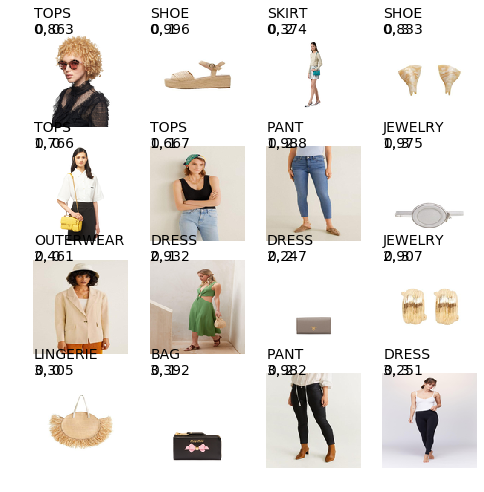

In [0]:
def plot_predictions(images, label, confidence):
  n = images.shape[0]
  nc = int(np.ceil(n / 4))
  f, axes = pyplot.subplots(nc, 4)
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    axes[x, y].text(0.5, 0.5, "{}, {}".format(x,y), fontsize=14)
    axes[x, y].text(0.5, 0.5, label[i] + '\n%.3f' % max(confidence[i]), fontsize=14)

  pyplot.gcf().set_size_inches(8, 8)  

batch
plot_predictions(y[b:b+16], predictions[b:b+16], pred[b:b+16])